In [1]:
# load partial_linear from the same subfolder
from functions import *
import warnings
warnings.simplefilter("ignore", RuntimeWarning)
import numpy as np
import pandas as pd
# from missingpy import MissForest
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import norm
import time


df = pd.read_csv("iwpc_prob.csv", index_col=0)
delta_class = np.array(df['Outcome']).reshape(-1,1)
T = np.array(df['Therapeutic Dose of Warfarin']).reshape(-1,1)
Y_prob = np.array(df['soft_labels']).reshape(-1,1)
Y = np.log((Y_prob + .000005) / (1.00005 - Y_prob))
X = df.drop(columns=['Therapeutic Dose of Warfarin',
                    'Outcome',
                    'soft_labels'
                    ])
column_names = X.columns
X = X.values
n,p = X.shape
Z = np.concatenate([X, T, Y, Y_prob, delta_class], axis=1)




Z_train, Z_test = train_test_split(Z, test_size=0.05, random_state=42)
X_train = Z_train[:, :p]
T_train = Z_train[:, p]
Y_train = Z_train[:, p + 1]
Y_prob_train = Z_train[:, p + 2]
delta_class_train = Z_train[:, p + 3]

X_test = Z_test[:, :p]
T_test = Z_test[:, p]
Y_test = Z_test[:, p + 1]
Y_prob_test = Z_test[:, p + 2]
delta_class_test = Z_test[:, p + 3]

In [3]:
seed = 42
np.random.seed(seed)
best_h, best_lam = n**(-0.2), 0.0
bootstrap_XI_opt = []
bootstrap_BETA_opt = []
num_bootstrap_samples = 10  # Choose a suitable number
for i in range(num_bootstrap_samples):
    indices = np.random.choice(X_train.shape[0], X_train.shape[0], replace=True)
    X_resampled = X_train[indices, :]
    Y_resampled = Y_train[indices]
    T_resampled = T_train[indices]
    XI_opt_bs, BETA_opt_bs, _, _ = hyperopt_train(X_resampled, Y_resampled, T_resampled, best_h, objective_func=objective_lasso, lam=best_lam, max_evals=100)
    bootstrap_XI_opt.append(XI_opt_bs)
    bootstrap_BETA_opt.append(BETA_opt_bs)
bootstrap_XI_opt = np.array(bootstrap_XI_opt)
bootstrap_BETA_opt = np.array(bootstrap_BETA_opt)
mean_XI_opt = np.mean(bootstrap_XI_opt, axis=0)
mean_BETA_opt = np.mean(bootstrap_BETA_opt, axis=0)
conf_interval_XI_opt = np.percentile(bootstrap_XI_opt, [2.5, 97.5], axis=0)
conf_interval_BETA_opt = np.percentile(bootstrap_BETA_opt, [2.5, 97.5], axis=0)



data_XI = pd.DataFrame(bootstrap_XI_opt, columns=column_names)
data_BETA = pd.DataFrame(bootstrap_BETA_opt, columns=column_names)

# # Plot for XI_opt
# import seaborn as sns
# plt.figure(figsize=(12, 8))
# sns.boxplot(data=data_XI, orient='h')
# plt.title('Bootstrapped Estimates of XI with 95% CI')
# plt.xlabel('Value')
# plt.ylabel('Feature')
# plt.show()

# # Plot for BETA_opt
# plt.figure(figsize=(12, 8))
# sns.boxplot(data=data_BETA, orient='h')
# plt.title('Bootstrapped Estimates of BETA with 95% CI')
# plt.xlabel('Value')
# plt.ylabel('Feature')
# plt.show()



100%|██████████| 100/100 [00:47<00:00,  2.12trial/s, best loss: 3.933299504169223]


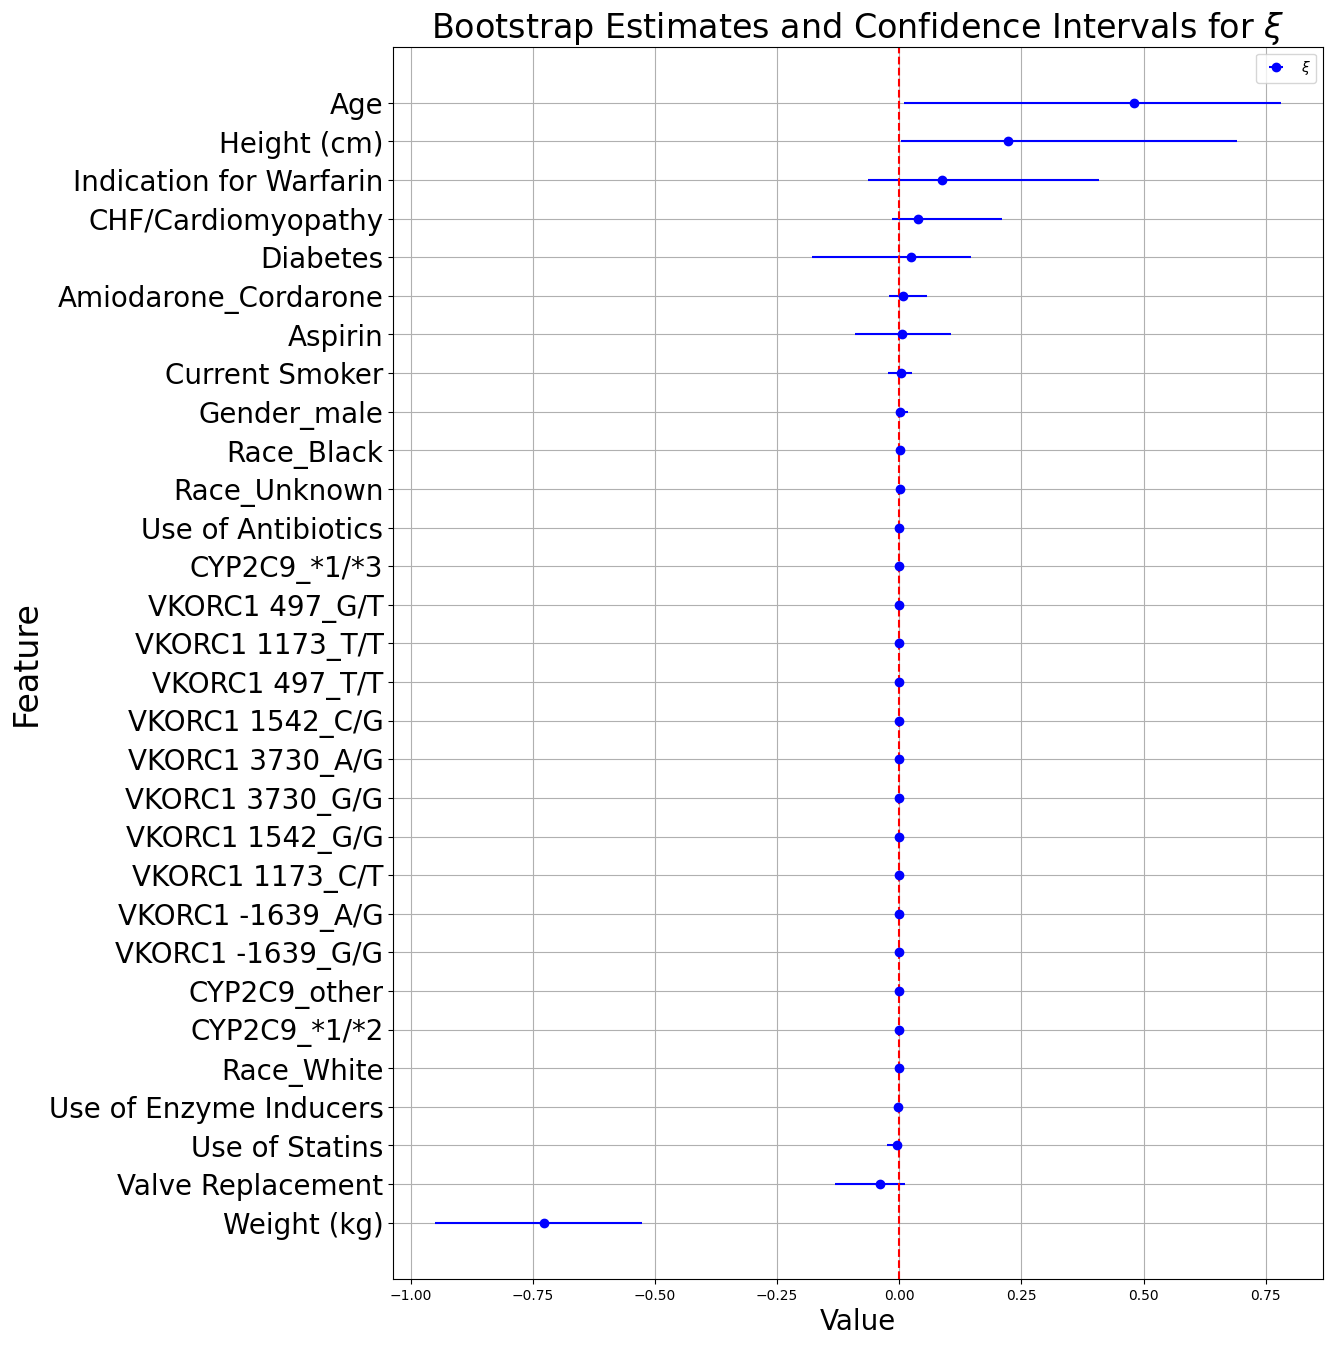

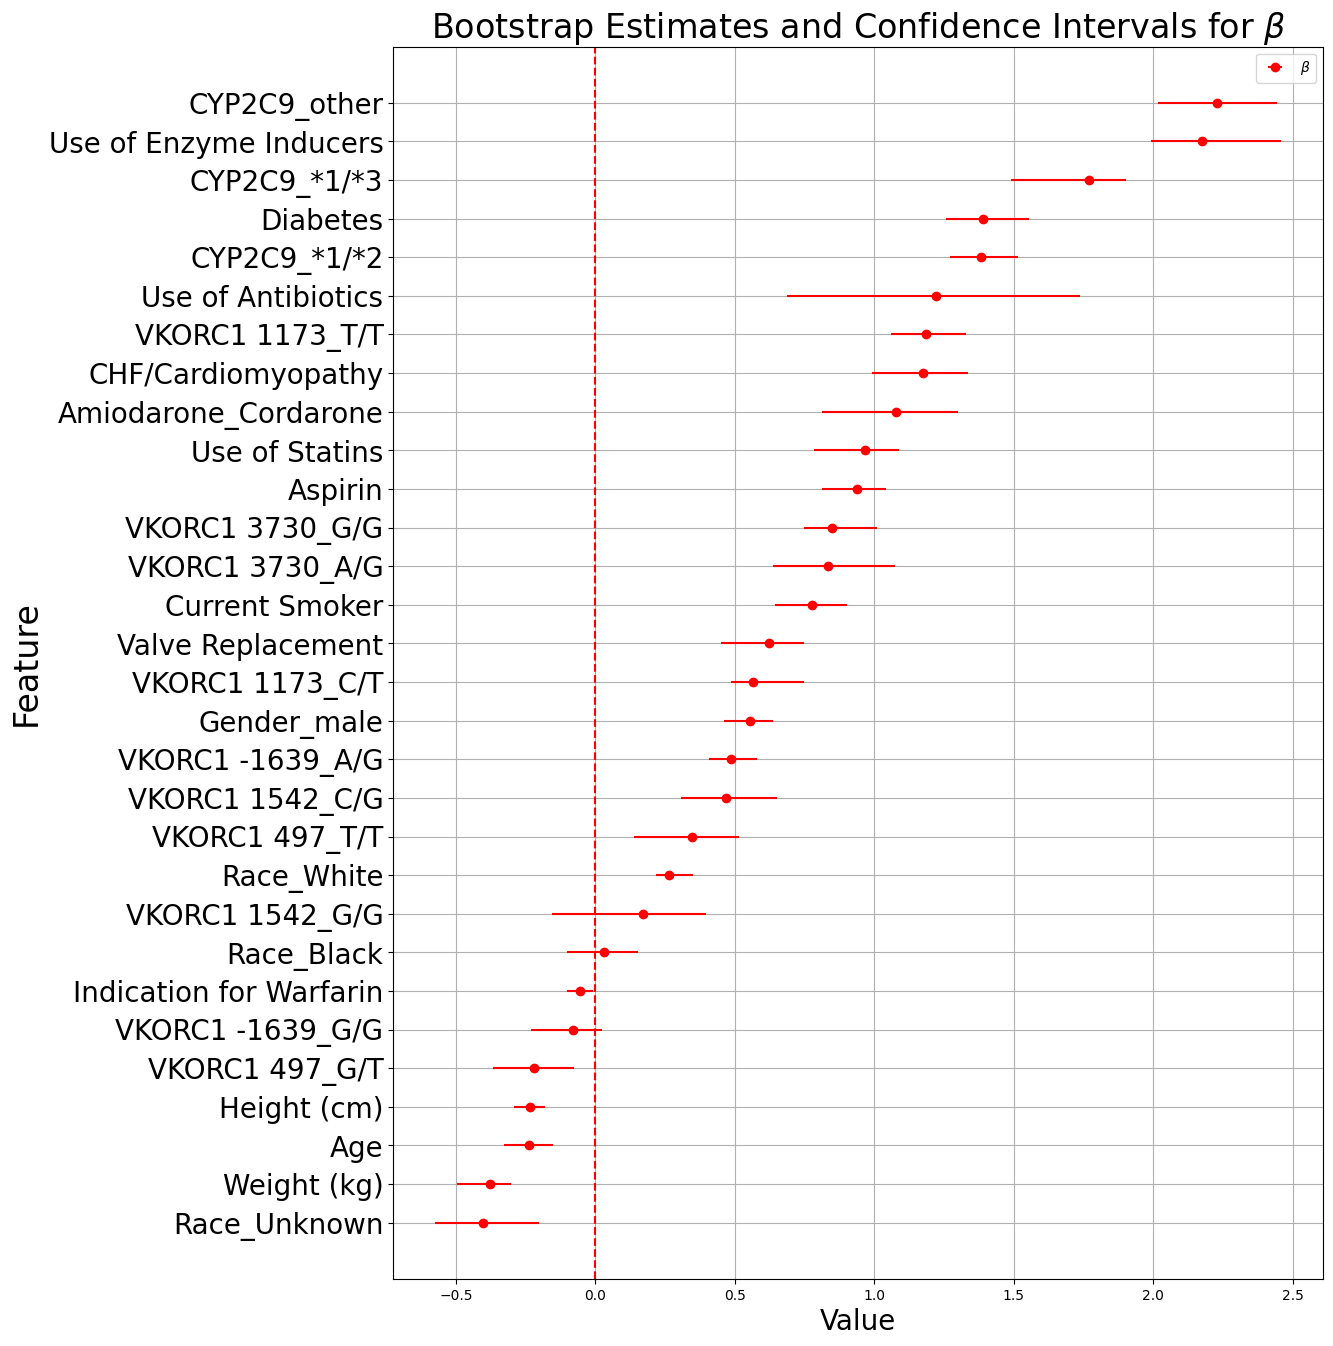

In [4]:


# Plot for XI
def plot_sorted_errorbar(column_names, mean_values, conf_intervals, name, color):
    sorted_indices = sorted(range(len(mean_values)), key=lambda k: mean_values[k], reverse=True)
    sorted_columns = [column_names[i] for i in sorted_indices]
    sorted_means = [mean_values[i] for i in sorted_indices]
    sorted_conf_intervals = conf_intervals[:, sorted_indices]

    plt.figure(figsize=(12, 16))
    plt.errorbar(sorted_means, range(len(sorted_columns)), 
                 xerr=[sorted_means - sorted_conf_intervals[0], 
                       sorted_conf_intervals[1] - sorted_means],
                 fmt='o', color=color, label=name)

    plt.axvline(0, color='red', linestyle='--')
    plt.yticks(range(len(sorted_columns)), sorted_columns,fontsize = 20)
    plt.title(f'Bootstrap Estimates and Confidence Intervals for {name}', fontsize = 24)
    plt.xlabel('Value',fontsize = 20)
    plt.ylabel('Feature',fontsize = 24)
    plt.legend()
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.show()


column_names = ['Age', 'Height (cm)', 'Weight (kg)',
       'Indication for Warfarin', 'Diabetes',
       'CHF/Cardiomyopathy', 'Valve Replacement',
       'Aspirin', 'Amiodarone_Cordarone', 'Current Smoker', 'Use of Statins',
       'Use of Enzyme Inducers', 'Use of Antibiotics', 'Gender_male',
       'Race_Black', 'Race_Unknown',
       'Race_White', 'CYP2C9_*1/*2', 'CYP2C9_*1/*3',
       'CYP2C9_other', 'VKORC1 -1639_A/G',
       'VKORC1 -1639_G/G', 'VKORC1 497_G/T',
       'VKORC1 497_T/T', 'VKORC1 1173_C/T',
       'VKORC1 1173_T/T', 'VKORC1 1542_C/G',
       'VKORC1 1542_G/G', 'VKORC1 3730_A/G',
       'VKORC1 3730_G/G']
# Usage for XI
plot_sorted_errorbar(column_names, mean_XI_opt, conf_interval_XI_opt, r'$\xi$', 'b')



# Plot for BETA
plot_sorted_errorbar(column_names, mean_BETA_opt, conf_interval_BETA_opt, r'$\beta$', 'r')



import json
import numpy as np

# Convert to list for JSON compatibility
data = {
    "mean_XI_opt": mean_XI_opt.tolist(),
    "conf_interval_XI_opt": conf_interval_XI_opt.tolist(),
    "mean_BETA_opt": mean_BETA_opt.tolist(),
    "conf_interval_BETA_opt": conf_interval_BETA_opt.tolist()
}

# Save as JSON
with open("data.json", "w") as file:
    json.dump(data, file)